Before starting this notebook make sure that:
1. You have generated datasets for google-siglip2-base-patch16-512 model using the ../../dataset_generation/generation.sh script
2. You have trained your weights or taken already trained weights and placed them in the ../precalculated_weights folder

In [1]:
device = 'cuda:0'
vision_model_name = 'google/siglip2-base-patch16-512'
feature_extractor_weights_dir = '../../feature_extractor_weights'
reconstructor_weights_path = '../precalculated_weights/models--google--siglip2-base-patch16-512.pt'
json_path = f'../../generated_datasets/{"-".join(vision_model_name.split("/"))}/map_val.json'

## Let's verify that the files and directories exist:

The feature_extractor_weights_dir folder and the json_path file should appear after the dataset generation.

In [2]:
import os
print('dir with feature extractor weights: ', os.path.isdir(feature_extractor_weights_dir))
print('file with weights of reconstructor R: ', os.path.isfile(reconstructor_weights_path))
print('file with pathes to data: ', os.path.isfile(json_path))

dir with feature extractor weights:  True
file with weights of reconstructor R:  True
file with pathes to data:  True


## Downloading the feature extractor.

In [3]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from transformers import SiglipVisionConfig, AutoImageProcessor, SiglipVisionModel

class SigLipVisionTower(nn.Module):
    def __init__(self, vision_model_name, weights_dir):
        super().__init__()

        self.is_loaded = False

        self.vision_tower_name = vision_model_name
        self.weights_dir = weights_dir
        self.processor_path = 'facebook/dinov2-base'
        self.select_layer = -2
        self.cfg_only = SiglipVisionConfig.from_pretrained(self.vision_tower_name, cache_dir=self.weights_dir)

    def load_model(self, device_map=None):
        if self.is_loaded:
            return

        self.image_processor = AutoImageProcessor.from_pretrained(self.processor_path, 
                                                                  cache_dir=self.weights_dir, 
                                                                  crop_size={"height": self.cfg_only.image_size, 
                                                                             "width": self.cfg_only.image_size},
                                                                  image_mean=[0.5, 0.5, 0.5], 
                                                                  image_std=[0.5, 0.5, 0.5], 
                                                                  size={"shortest_edge": self.cfg_only.image_size})
        self.vision_tower = SiglipVisionModel.from_pretrained(self.vision_tower_name, 
                                                              cache_dir=self.weights_dir, 
                                                              device_map=device_map)

        self.vision_tower.vision_model.head = nn.Identity()
        self.vision_tower.requires_grad_(False)
        self.eval()

        self.is_loaded = True

    def forward(self, images):
        if type(images) is list:
            image_features = []
            for image in images:
                image_forward_out = self.vision_tower(image.to(device=self.device, dtype=self.dtype).unsqueeze(0), output_hidden_states=True)
                image_feature = image_forward_out.hidden_states[self.select_layer].to(image.dtype)
                image_features.append(image_feature)
        return image_features

    @property
    def dtype(self):
        for p in self.vision_tower.parameters():
            return p.dtype

    @property
    def device(self):
        for p in self.vision_tower.parameters():
            return p.device

    @property
    def config(self):
        if self.is_loaded:
            return self.vision_tower.config
        else:
            return self.cfg_only

    @property
    def hidden_size(self):
        return self.config.hidden_size

    @property
    def num_patches(self):
        return (self.config.image_size // self.config.patch_size) ** 2

    @property
    def num_patches_per_side(self):
        return self.config.image_size // self.config.patch_size

    @property
    def image_size(self):
        return self.config.image_size
    
vision_tower = SigLipVisionTower(vision_model_name, feature_extractor_weights_dir)
vision_tower.load_model(device_map=device)

/home/jovyan/.mlspace/envs/nips-interpretation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### For each image, I create an analog of it by suppressing of b channel.

I will practice on five pictures, and on the other five I will check the result. It turns out that five pictures are enough to learn the required linear transformation, but the more the better!

In [4]:
IMAGE_PREFIX = "../../"

In [5]:
import json
import numpy as np
from PIL import Image
from tqdm import tqdm

ALPHA = 0.2

def rgb_to_bgr(im):
    gbr_im = np.array(im, dtype=np.float32)
    gbr_im[:, :, 2:] *= ALPHA
    gbr_im = np.array(gbr_im, dtype=np.uint8)
    gbr_im = Image.fromarray(gbr_im).convert('RGB')
    return gbr_im


def load_and_process_images(json_path, processor, number):
    with open(json_path, 'r') as json_file:
        json_dict = json.load(json_file)

    ###################### images_list #########################
    images_pathes_list = []
    for i, (im_path, _) in enumerate(json_dict.items()):
        if i == number: break
        images_pathes_list.append(im_path)
    images_list = [Image.open(p).convert('RGB') for p in tqdm(images_pathes_list)]

    ###################### gbr_images_list #########################
    processed_images_list = []
    for im in tqdm(images_list):
        gbr_im = processor(im)
        processed_images_list.append(gbr_im)
    
    return images_list, processed_images_list


N_train, N_val = 5, 5
all_images_list, all_processed_images_list = load_and_process_images(json_path, rgb_to_bgr, number=N_train + N_val)

images_list, processed_images_list = all_images_list[-N_train:], all_processed_images_list[-N_train:]
val_images_list, val_processed_images_list = all_images_list[:N_val], all_processed_images_list[:N_val]

100%|██████████| 10/10 [00:00<00:00, 683.02it/s]


### Counting features for initial and modified images.

In [6]:
IMAGE_SIZE = 32

In [7]:
import numpy as np
from tqdm import tqdm
from torch.nn import functional as F


@torch.no_grad()
def calc_feature(me):
    inputs = vision_tower.image_processor(me, return_tensors="pt")['pixel_values'].to(device)[0]
    features = vision_tower([inputs])

    features = features[0].reshape(IMAGE_SIZE, IMAGE_SIZE, 768)
    features = features.permute(2, 0, 1)
    features = features / features.norm(dim=0, keepdim=True)
    return inputs, features


def calc_features_for_images_and_processed_images(images_list, processed_images_list):
    inputs_list = []
    feature_list = []
    for im in tqdm(images_list):
        inputs, features = calc_feature(im)
        inputs_list.append(inputs.cpu())
        feature_list.append(features.cpu())

    processed_inputs_list = []
    processed_feature_list = []
    for im in tqdm(processed_images_list):
        inputs, features = calc_feature(im)
        processed_inputs_list.append(inputs.cpu())
        processed_feature_list.append(features.cpu())
    
    return inputs_list, feature_list, processed_inputs_list, processed_feature_list

inputs_list, feature_list, processed_inputs_list, processed_feature_list = calc_features_for_images_and_processed_images(images_list, processed_images_list)

  0%|          | 0/5 [00:00<?, ?it/s]/home/jovyan/.mlspace/envs/nips-interpretation/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1716578970623/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 5/5 [00:00<00:00, 29.11it/s]


In [8]:
features = torch.stack(feature_list).to(device)
processed_feature = torch.stack(processed_feature_list).to(device)

### Compute the orthogonal matrix on the training sample:

In [9]:
features.shape

torch.Size([5, 768, 32, 32])

In [10]:
def calculate_Q(real_F, gbr_F): # [1024, 1024]
    Q = torch.linalg.inv(real_F.permute(1, 0) @ real_F) @ real_F.permute(1, 0) @ gbr_F
    return Q

Q = calculate_Q(features.permute(2, 3, 0, 1).flatten(0, 2),
                processed_feature.permute(2, 3, 0, 1).flatten(0, 2))

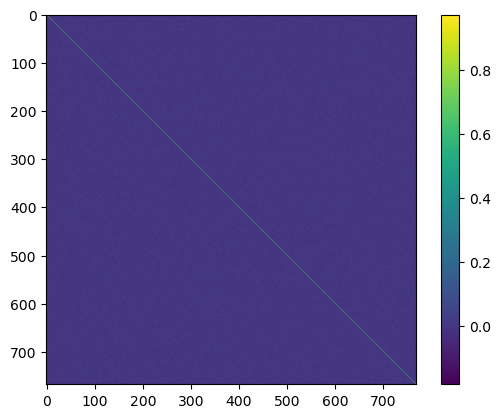

In [11]:
import matplotlib.pyplot as plt
plt.imshow(Q.cpu())
plt.colorbar()

### Apply the transformation and restore the changed fiches on the validation sample.

In [12]:
def apply_Q(Fe, Q, n=1):
    gbr_Fe = torch.zeros_like(Fe)

    Qn = Q
    for _ in range(n - 1):
        Qn = Qn @ Q

    for i in range(Fe.shape[1]):
        for j in range(Fe.shape[2]):
            gbr_Fe[:, i, j] = Fe[:, i, j] @ Qn
    
    gbr_Fe /= gbr_Fe.norm(dim=0, keepdim=True)
    return gbr_Fe


@torch.no_grad()
def interpolate(im, Fe, model, device):
    processed_image = torch.tensor(im).to(device)
    processed_Fe = Fe.to(device)
    reconstructed_image, processed_Fe, check_dict = model.forward(processed_Fe, processed_image)
    return processed_image, reconstructed_image, processed_Fe, check_dict

image_mean = np.array(vision_tower.image_processor.image_mean)
image_std = np.array(vision_tower.image_processor.image_std)
def from_1_to_255(image, image_mean, image_std):
    image_unnormed = np.asarray(image) * image_std[:, None, None] + image_mean[:, None, None]
    image_01 = image_unnormed.clip(0, 1)
    image_255 = image_01 * 255
    image_255_uint = np.array(image_255, dtype=np.uint8)
    return image_255_uint

In [13]:
import torch.nn.functional as F
from PIL import Image

def Qed(images_list, Q, n=1):
    inputs_list, features_list, Qed_features_list, processed_inputs_list, processed_features_list = [], [], [], [], []

    for im in tqdm(images_list):
        inputs, features = calc_feature(im)
        processed_inputs, processed_features = calc_feature(rgb_to_bgr(im))
        Qed_me_features = apply_Q(features, Q, n)

        inputs_list.append(inputs)
        features_list.append(features)
        processed_inputs_list.append(processed_inputs)
        processed_features_list.append(processed_features)
        Qed_features_list.append(Qed_me_features)

    return inputs_list, features_list, Qed_features_list, processed_inputs_list, processed_features_list

In [14]:
def interpolate_all_features(model, 
                             inputs_list, features_list, Qed_features_list, 
                             processed_inputs_list, processed_features_list):
    inter_list, rec_list, processed_inter_list, processed_rec_list, Qed_rec_list = [], [], [], [], []
    
    z = zip(tqdm(inputs_list), features_list, Qed_features_list, processed_inputs_list, processed_features_list)
    for inputs, features, Qed_features, processed_inputs, processed_features in z:
        inter, rec, _, _ = interpolate(inputs[None], features[None], model, device)
        _, Qed_rec, _, _ = interpolate(inputs[None], Qed_features[None], model, device)
        processed_inter, processed_rec, _, _ = interpolate(processed_inputs[None], processed_features[None], model, device)

        inter = from_1_to_255(inter[0].cpu(), image_mean, image_std)
        rec = from_1_to_255(rec[0].cpu(), image_mean, image_std)
        processed_inter = from_1_to_255(processed_inter[0].cpu(), image_mean, image_std)
        processed_rec = from_1_to_255(processed_rec[0].cpu(), image_mean, image_std)
        Qed_rec = from_1_to_255(Qed_rec[0].cpu(), image_mean, image_std)

        inter_list.append(inter)
        rec_list.append(rec)
        processed_inter_list.append(processed_inter)
        processed_rec_list.append(processed_rec)
        Qed_rec_list.append(Qed_rec)

    return inter_list, rec_list, processed_inter_list, processed_rec_list, Qed_rec_list

### Draw the result.

In [15]:
import matplotlib.pyplot as plt

def draw_examples(inter_list, rec_list, processed_inter_list, processed_rec_list, Qed_rec_list, 
         title_4=''):
    ncols, nrows, scale = 5, len(inter_list), 3
    _, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * scale, (nrows + 1) * scale))

    for i in range(nrows):
        axes[i, 0].imshow(inter_list[i].transpose(1, 2, 0))
        axes[i, 1].imshow(rec_list[i].transpose(1, 2, 0))
        axes[i, 2].imshow(processed_inter_list[i].transpose(1, 2, 0))
        axes[i, 3].imshow(processed_rec_list[i].transpose(1, 2, 0))
        axes[i, 4].imshow(Qed_rec_list[i].transpose(1, 2, 0))

        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
        axes[i, 3].axis('off')
        axes[i, 4].axis('off')

        if i == 0:
            axes[i, 0].set_title('RGB image\n')
            axes[i, 1].set_title('RGB image\n' + 'reconstruction')
            axes[i, 2].set_title(f'RG({ALPHA}*B) image\n')
            axes[i, 3].set_title(f'RG({ALPHA}*B) image\n' + 'reconstruction')
            axes[i, 4].set_title(title_4)

    plt.show()

### Draw the eigenvalues.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def draw_eigs(Q, Qed_rec, title_1, title_2, title_3, strike_out=False):
    L, _ = torch.linalg.eig(Q)
    L_np = L.cpu().numpy()

    pad = 20
    ncols, nrows, scale = 1, 3, 3
    _, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * scale, (nrows) * scale), constrained_layout=True)

    axes[0].imshow(Qed_rec.transpose(1, 2, 0))
    if strike_out:
        x = np.linspace(0, 512, 100)
        axes[0].plot(x, x, '--', c='red', linewidth=3)
        axes[0].plot(x, 512 - x, '--', c='red', linewidth=3)

    axes[0].axis('off')
    axes[0].axis('equal')
    axes[0].set_title(title_1, pad=pad)


    theta = np.linspace(0, 2*np.pi, 100)
    axes[1].scatter(L_np.real, L_np.imag, alpha=0.5, color='red')
    axes[1].plot(np.cos(theta), np.sin(theta), 'b-', linewidth=1.5, alpha=0.7)
    axes[1].axhline(0, color='black', linewidth=0.5, linestyle='--')
    axes[1].axvline(0, color='black', linewidth=0.5, linestyle='--')

    axes[1].set_xlabel('Re')
    axes[1].set_ylabel('Im')
    axes[1].set_title(title_2, pad=pad)
    axes[1].grid(True, linestyle=':', alpha=0.7)
    axes[1].axis('equal')

    axes[2].scatter(torch.arange(len(L)), L.cpu().abs(), s=10)
    axes[2].set_ylabel('Modulus')
    axes[2].set_xlabel('Number of eigenvalues')
    axes[2].set_title(title_3, pad=pad)

    plt.show()

In [17]:
def draw_matrix(Q):
    plt.figure(figsize=(3, 3))
    plt.imshow(Q.cpu())
    plt.colorbar()
    plt.show()

# Application:

In [18]:
from model import VQVAE
model = VQVAE(vision_model_name).to(device)
model.load_state_dict(torch.load(reconstructor_weights_path, weights_only=True), strict=True)
model.eval();

You are using a model of type siglip_vision_model to instantiate a model of type clip_vision_model. This is not supported for all configurations of models and can yield errors.


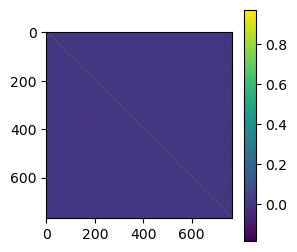

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_2852962/1324944990.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_image = torch.tensor(im).to(device)
100%|██████████| 5/5 [00:01<00:00,  4.76it/s]


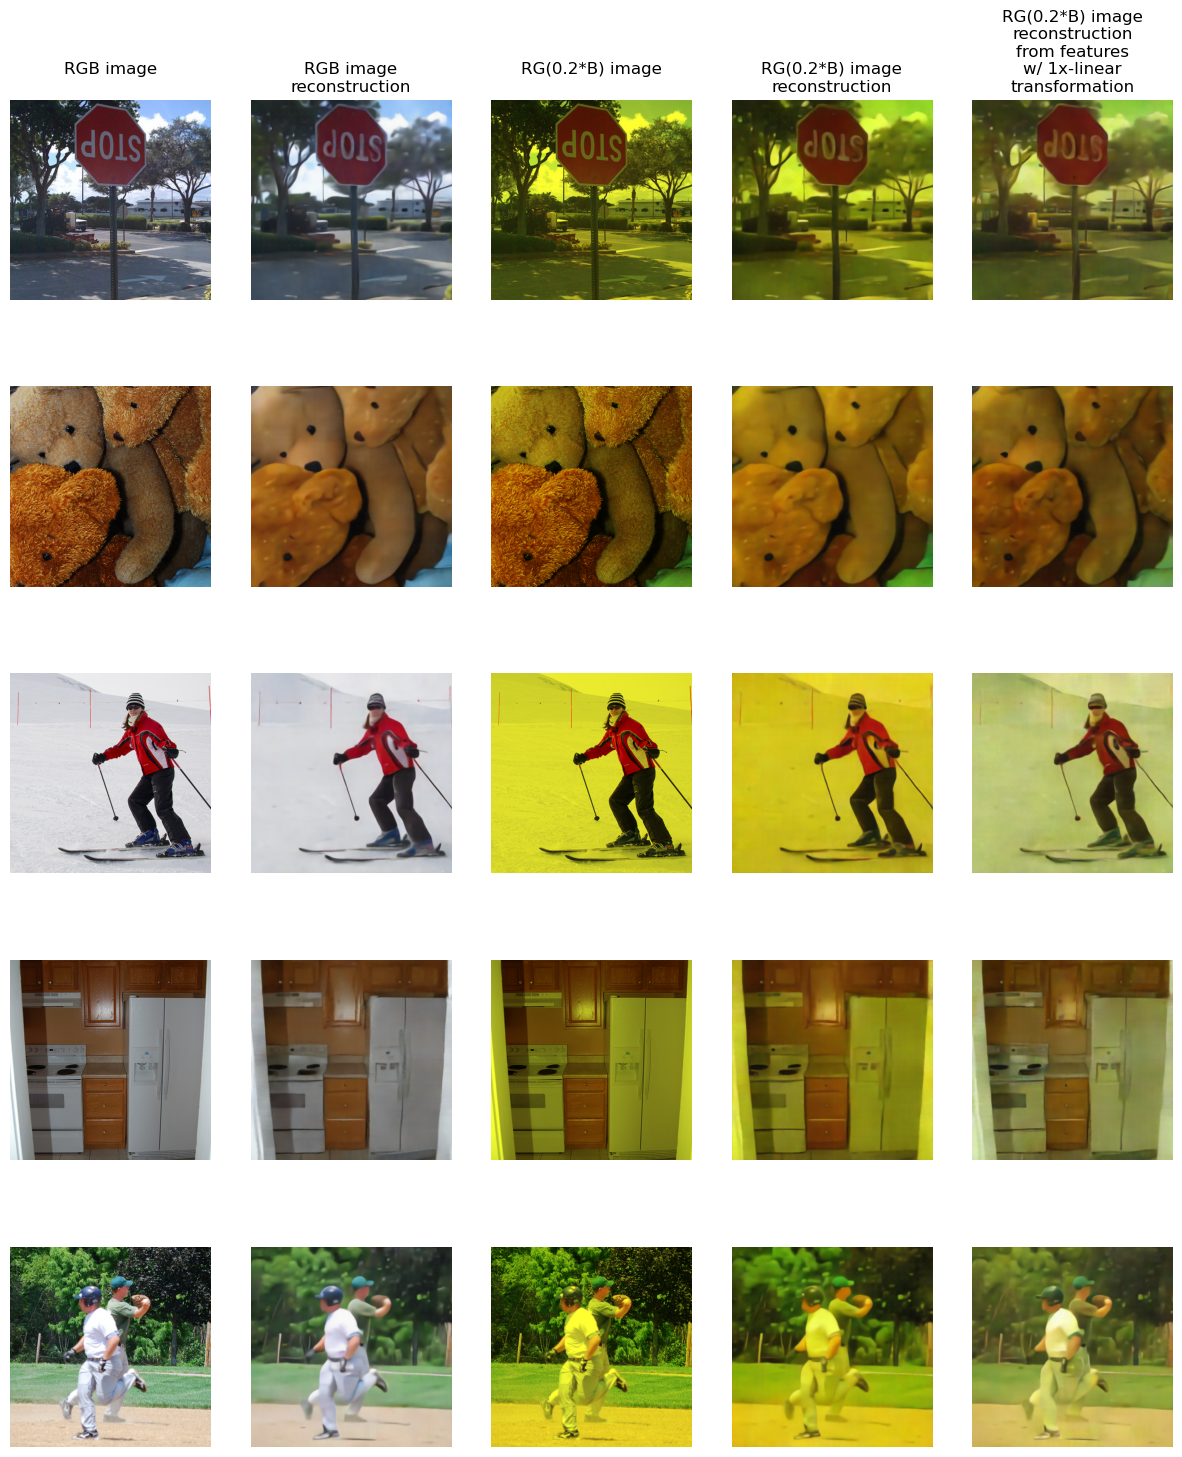

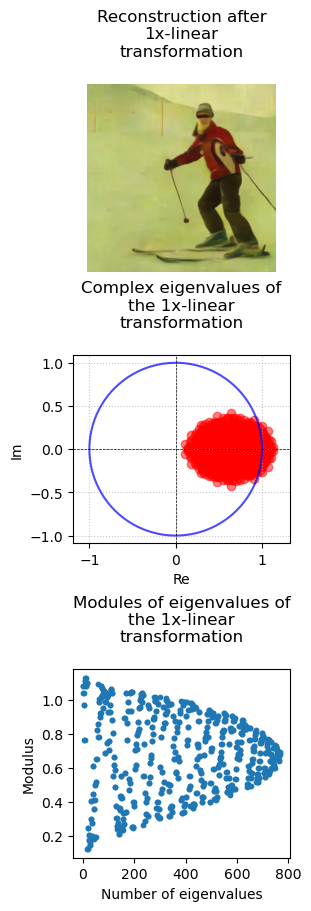

In [19]:
ns = [1]
for n in ns:
    Q = calculate_Q(features.permute(2, 3, 0, 1).flatten(0, 2), processed_feature.permute(2, 3, 0, 1).flatten(0, 2))
    draw_matrix(Q)

    inputs_list, features_list, Qed_features_list, processed_inputs_list, processed_features_list = Qed(val_images_list[:10], Q, n=n)
    inter_list, rec_list, processed_inter_list, processed_rec_list, Qed_rec_list = \
    interpolate_all_features(model, inputs_list, features_list, Qed_features_list, processed_inputs_list, processed_features_list)
    draw_examples(inter_list, rec_list, processed_inter_list, processed_rec_list, Qed_rec_list,
                title_4=f'RG({round(ALPHA**n, 2)}*B) image\n' + 'reconstruction\n' + 'from features\n' + f'w/ {n}x-linear\n' + 'transformation',
                )
    
    Qn = Q
    for j in range(n-1): Qn = Qn @ Q
    draw_eigs(Qn, Qed_rec_list[2],
            title_1='Reconstruction after\n' + f'{n}x-linear\n' + 'transformation', 
            title_2='Complex eigenvalues of\n' + f'the {n}x-linear\n' + 'transformation', 
            title_3='Modules of eigenvalues of\n' + f'the {n}x-linear\n' + 'transformation')